In [1]:
import pandas as pd
import os

In [3]:
os.chdir(r'./data')

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
lb = pd.read_csv('loan_before.csv')

In [7]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [9]:
lb.columns

Index(['SK_ID_CURR', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'CREDIT_TYPE'],
      dtype='object')

# 1. 문제 정의

<b>질문 1</b>. 어떤 요소가 대출금 상환 여부에 큰 영향을 줄까?\
<b>
질문</b> 2. 그리고 그 요소들은 대출금 상환 여부에 어떤 영향을 미칠까?

# 2. 방법론

## 2.1 분석과정
이 질문에 대한 해답을 얻기 위해서 해석 가능한 머신러닝(xAI)을 활용하였다

<b>process</b>\
step 1: Feature Enginerring\
step 2: machine learning modelling\
step 3: Shap value를 통해 어떤 변수가 가장 큰 영향력을 가지는지 알아본다\
step 4: 영향을 많이 주는 5개의 변수와 대출금 상환 여부와의 관계를 살펴본다. 

## 2.2 Feature engineering

AMT_CREDIT 에서 AMT_ANNUITY를 나누어 해당 사람이 몇 개월에 걸쳐 돈을 갚아야 하는지 변수화 하였다. 

In [24]:
train['AMT_CREDIT_TO_ANNUITY_RATIO'] = train['AMT_CREDIT']/train['AMT_ANNUITY']
test['AMT_CREDIT_TO_ANNUITY_RATIO'] = test['AMT_CREDIT']/test['AMT_ANNUITY']

lb(이전에 대출한 정보가 기록된 데이터)를 활용해 변수 생성을 시도하였다\
\
<b>1. groupby 후 평균 (사람 ID로 묶은 후 각 변수 평균을 냄)</b>
   <ul>
       <li>AMT_CREDIT_SUM - 이전 대출의 금액</li>
       <li>DAYS_CREDIT - train, test 로 부터 며칠 전에 이전 대출을 진행했는지</li>
       <li>CNT_CREDIT_PROLONG - 대출연장을 몇 번 했는지</li>
   </ul>
<b>2. groupby 후 행의 갯수 (사람 ID별로의 빈도수, 해당 사람이 이전에 대출을 몇 번 진행했는지)</b>

In [36]:
train = pd.merge(train, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(), on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(), on = 'SK_ID_CURR', how = 'left')

In [40]:
train = pd.merge(train, lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(), on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(), on = 'SK_ID_CURR', how = 'left')

train = pd.merge(train, lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(), on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(), on = 'SK_ID_CURR', how = 'left')

In [50]:
train = pd.merge(train, lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns = {0:'count'}), on='SK_ID_CURR', how = 'left')
test = pd.merge(test, lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns = {0:'count'}), on='SK_ID_CURR', how = 'left')

해당 프로젝트의 주 목적은 모델 해석이기 때문에 이에 방해를 주는 변수는 다 삭제하였다\
\
<b>제거한 변수 목록</b>
<ul>
<li>CODE_GENDER: 범주형 변수</li>
<li>FLAG_OWN_CAR: 범주형 변수</li>
<li>NAME_TYPE_SUITE: 범주형 변수</li>
<li>NAME_INCOME_TYPE: 범주형 변수</li>
<li>NAME_EDUCATION_TYPE: 범주형 변수</li>
<li>NAME_HOUSING_TYPE: 범주형 변수</li>
<li>ORGANIZATION_TYPE: 범주형 변수</li>
<li>EXT_SOURCE_1: 변수의 의미를 정확히 알 수 없음</li>
<li>EXT_SOURCE_2: 변수의 의미를 정확히 알 수 없음</li>
<li>EXT_SOURCE_3: 변수의 의미를 정확히 알 수 없음</li>
</ul>

In [56]:
# 범주 의미를 갖는 변수들, 해석 할 수 없는 변수들
del_list = ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'ORGANIZATION_TYPE','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [58]:
train = train.drop(del_list, axis = 1)
test = test.drop(del_list, axis = 1)

In [60]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

## 2.3. Modelling

### 모델링을 하기 전, 서로 상관관계가 높은 input 변수를 삭제한다
이유: input 변수가 높은 상관성을 띌 때 shap value는 제대로 된 설명력을 발휘하지 못함

In [75]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

In [81]:
corr = train[input_var].corr()
corr.style.background_gradient(cmap = 'coolwarm')

,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
FLAG_OWN_REALTY,1.000000,0.008244,0.003243,-0.042446,-0.001448,0.010826,-0.110930,-0.015164,0.004217,0.019393,0.014595,-0.105580,0.026066,0.090058,-0.083920,-0.002745,0.000174,-0.009790,0.008414
CNT_CHILDREN,0.008244,1.000000,0.029879,0.006465,0.023275,-0.033326,0.332123,0.068807,-0.029581,-0.010951,0.883051,-0.009661,-0.006102,-0.036431,-0.022026,0.035864,0.026285,-0.012065,0.002649
AMT_INCOME_TOTAL,0.003243,0.029879,1.000000,0.366717,0.441573,0.185047,0.066875,-0.041696,0.029519,-0.126551,0.029342,0.092505,-0.040823,0.031593,0.077303,0.241929,-0.013266,0.016117,0.116635
AMT_CREDIT,-0.042446,0.006465,0.366717,1.000000,0.770938,0.092177,-0.047089,-0.085049,0.000988,-0.111244,0.066847,0.047472,-0.070924,-0.037907,0.656337,0.135435,-0.068411,-0.000384,0.046902
AMT_ANNUITY,-0.001448,0.023275,0.441573,0.770938,1.000000,0.127204,0.017106,-0.048381,0.013662,-0.108185,0.073912,0.047113,-0.058709,0.000270,0.111694,0.128144,-0.052613,-0.005724,0.013588
REGION_POPULATION_RELATIVE,0.010826,-0.033326,0.185047,0.092177,0.127204,1.000000,-0.023276,0.013870,0.000946,-0.088270,-0.025638,0.182730,-0.051167,0.015725,0.003524,0.077984,-0.010819,0.003701,-0.034289
DAYS_BIRTH,-0.110930,0.332123,0.066875,-0.047089,0.017106,-0.023276,1.000000,0.349373,0.266852,-0.015877,0.283729,0.087200,0.080317,-0.073904,-0.097736,0.053205,0.201829,0.028239,-0.063004
DAYS_EMPLOYED,-0.015164,0.068807,-0.041696,-0.085049,-0.048381,0.013870,0.349373,1.000000,0.093421,0.014016,0.032736,0.003502,0.144221,0.003833,-0.087176,-0.018131,0.160521,0.000124,-0.148704
DAYS_ID_PUBLISH,0.004217,-0.029581,0.029519,0.000988,0.013662,0.000946,0.266852,0.093421,1.000000,0.001141,-0.025311,0.029700,0.089952,-0.039895,-0.020280,0.033384,0.188471,0.022736,-0.100673
OWN_CAR_AGE,0.019393,-0.010951,-0.126551,-0.111244,-0.108185,-0.088270,-0.015877,0.014016,0.001141,1.000000,-0.039362,-0.082672,0.013561,-0.025423,-0.059224,-0.094781,-0.006665,0.011323,-0.025711


highly correlated
<ul>
    <li>CNT_FAM_MEMBERS, CNT_CHILDREN</li>
    <li>AMT_CREDIT_TO_ANNUITY_RATIO, AMT_CREDIT</li>
    <li>AMT_ANNUITY, AMT_CREDIT</li>
</ul>

CNT_FAM_MEMBERS와 CNT_CHILDREN 중 타겟값과 높은 correlation을 가진 변수는 CNT_CHILDREN이므로 CNT_FAM_MEMBERS를 삭제한다

In [91]:
print (train['CNT_FAM_MEMBERS'].corr(train['TARGET']))
print (train['CNT_CHILDREN'].corr(train['TARGET']))

0.018876651698723716
0.025357359317615746


In [93]:
del train['CNT_FAM_MEMBERS']
del test['CNT_FAM_MEMBERS']

'AMT_CREDIT_TO_ANNUITY_RATIO'와 'AMT_CREDIT' 중 타겟값과 높은 correlation을 가진 변수는 AMT_CREDIT_TO_ANNUITY_RATIO 이므로, AMT_CREDIT 을 삭제한다

In [96]:
print (train['AMT_CREDIT_TO_ANNUITY_RATIO'].corr(train['TARGET']))
print (train['AMT_CREDIT'].corr(train['TARGET']))

-0.024740288335190173
-0.0225584308493476


In [98]:
del train['AMT_CREDIT']
del test['AMT_CREDIT']

In [100]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

In [102]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

### xgboost를 활용해 모델링을 진행한다
이유: shap value를 활용하기 위해선 모델이 RandomForest형태의 tree형 모델이어야 한다. 그 중 xgboost가 속도가 빠르면서 높은 성능을 유지하므로 이를 선택

In [106]:
from xgboost import XGBClassifier

In [110]:
model = XGBClassifier(n_estimators = 100, learning_rate = 0.1)
model.fit(train[input_var], train['TARGET'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## 2.4 Shap value 활용

In [118]:
import shap

In [120]:
shap_values = shap.TreeExplainer(model).shap_values(train[input_var])

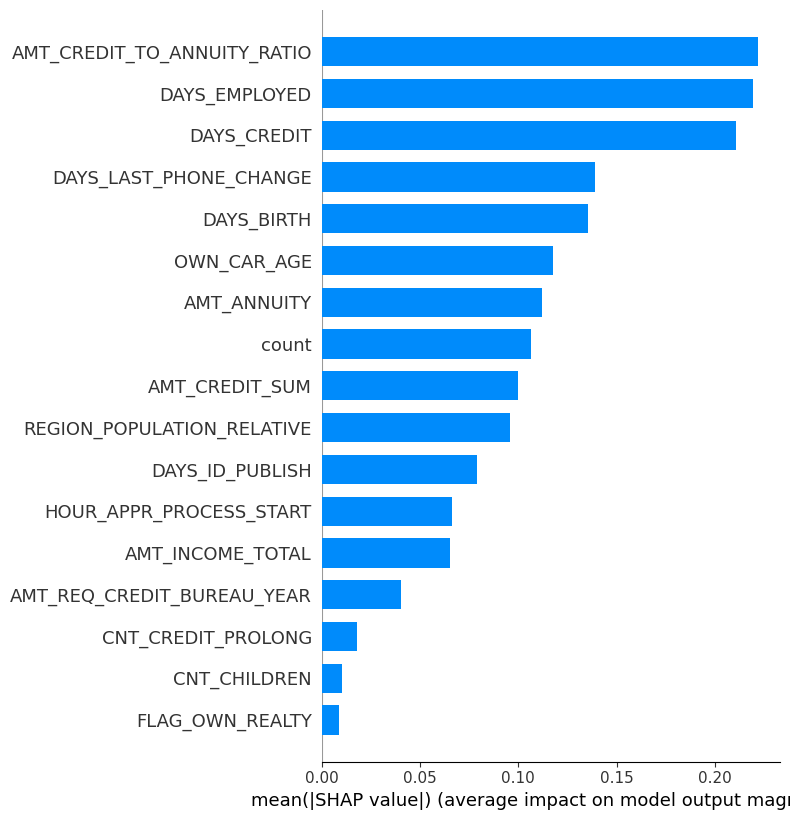

In [128]:
shap.summary_plot(shap_values, train[input_var], plot_type = 'bar')

타겟값에 가장 큰 영향을 미치는 top 5 변수:
<ul>
    <li>AMT_CREDIT_TO_ANNUITY_RATIO</li>
    <li>DAYS_EMPLOYED</li>
    <li>DAYS_CREDIT</li>
    <li>DAYS_LAST_PHONE_CHANGE</li>
    <li>DAYS_BIRTH</li>
</ul>

## 2.5 영향을 많이 주는 5개의 변수와 상환 여부와의 관계

### 1. AMT_CREDIT_TO_ANNUITY_RATIO

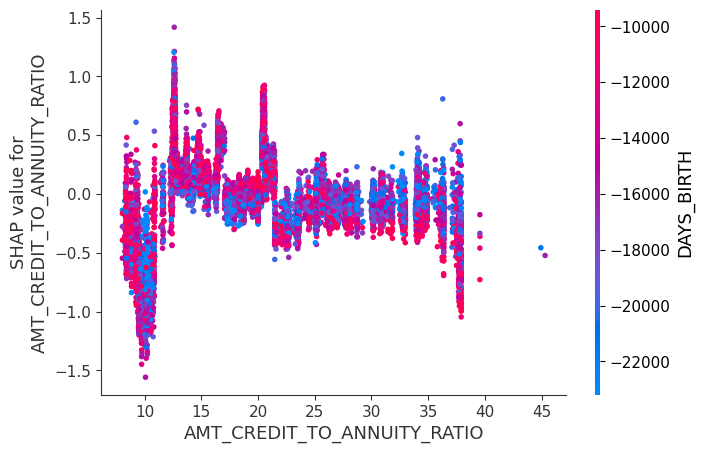

In [134]:
shap.dependence_plot('AMT_CREDIT_TO_ANNUITY_RATIO', shap_values, train[input_var])

대출 상환 기간이 12~20 개월 사이 일 때 비교적 상환 비율이 낮다\
반면 12개월 이하, 20개월 이상일 때는 상환 비율이 비교적 높다

### 2. DAYS_EMPLOYED

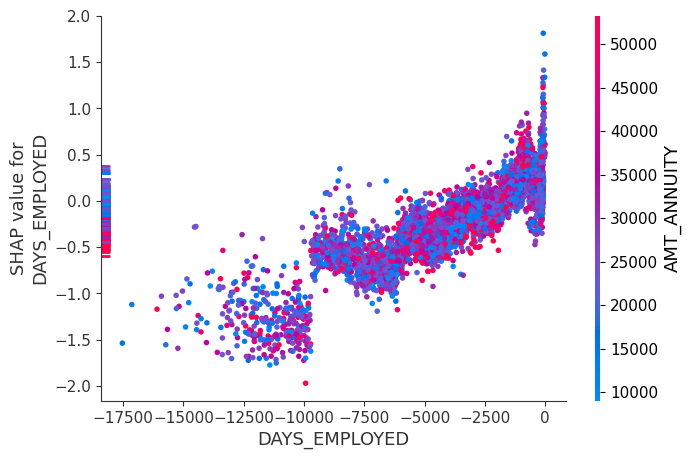

In [143]:
shap.dependence_plot('DAYS_EMPLOYED', shap_values, train[input_var])

취업한지 오래될 수록 대출 상환 확률이 올라간다. \
대출일 기준 9000일보다 오래 전에 취업했을 떄 대출 상환 능력이 급상한다.

### 3. DAYS_CREDIT

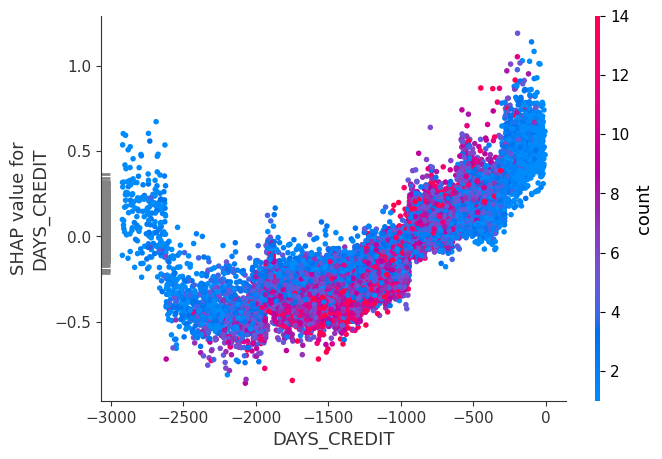

In [146]:
shap.dependence_plot('DAYS_CREDIT', shap_values, train[input_var])

DAYS_CREDIT은 -3000~-2000일 은 대출 상환 능력이 상승한다\
그 이후부턴 하락함

### 4. DAYS_LAST_PHONE_CHANGE

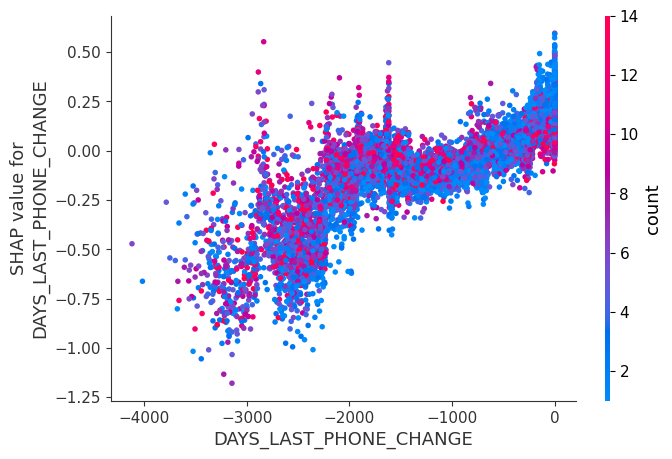

In [152]:
shap.dependence_plot('DAYS_LAST_PHONE_CHANGE', shap_values, train[input_var])

핸드폰을 바꾼지 오래될수록 대출금 상환 가능성이 높아짐

### 5. DAYS_BIRTH

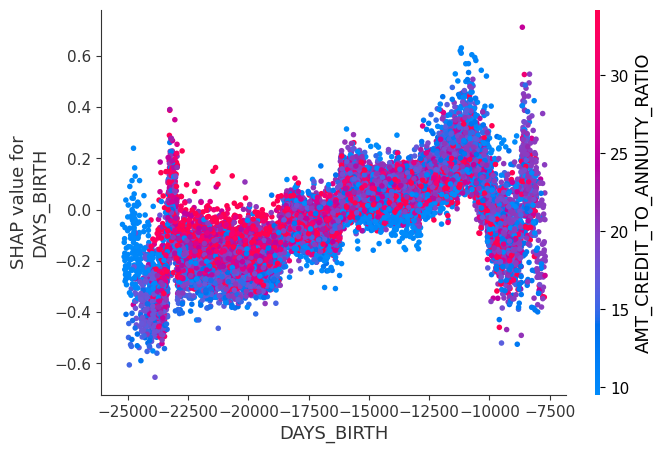

In [149]:
shap.dependence_plot('DAYS_BIRTH', shap_values, train[input_var])

나이가 많아질수록 대출금 상환을 잘 하는 경향이 있다.

# 3. 결론

1. 대출 상환 기간이 상환여부에 가장 큰 영향을 준다. 해당 영향은 비선형 관계임 (causality알 수 없음)
2. 주택 보유 여부와 자식의 수는 대출 상환 능력에 큰 영향을 미치지 않는다
3. 최근에 취업했을수록, 최근에 대출을 받았을수록, 최근에 핸드폰을 바꿨을수록 나이가 어릴수록 대출금 상환 가능성이 낮다 (DAYS_EMPLOYED, DAYS_CREDIT, DAYS_LAST_PHONE_CHANGE, DAYS_BIRTH가 클수록 대출금 상환 가능성이 낮다)TH(

## 3.1 마무리 시각화

train data를 DAYS_EMPLOYED, DAYS_CREDIT, DAYS_LAST_PHONE_CHANGE, DAYS_BIRTH값이 상위 25프로, 하위 25프로 값을 갖는 것들로 그룹화

In [171]:
group1 = train.loc[ (train['DAYS_EMPLOYED'].quantile(0.75)< train['DAYS_EMPLOYED']) & 
            (train['DAYS_CREDIT'].quantile(0.75)< train['DAYS_CREDIT']) &
            (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.75)< train['DAYS_LAST_PHONE_CHANGE']) &
            (train['DAYS_BIRTH'].quantile(0.75)< train['DAYS_BIRTH'])]

In [173]:
group2 = train.loc[ (train['DAYS_EMPLOYED'].quantile(0.25)> train['DAYS_EMPLOYED']) & 
            (train['DAYS_CREDIT'].quantile(0.25)> train['DAYS_CREDIT']) &
            (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.25)> train['DAYS_LAST_PHONE_CHANGE']) &
            (train['DAYS_BIRTH'].quantile(0.25)> train['DAYS_BIRTH'])]

In [177]:
group1['group'] = 1
group2['group'] = 0

C:\Users\RAZER\AppData\Local\Temp\ipykernel_3732\2022227829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['group'] = 1
C:\Users\RAZER\AppData\Local\Temp\ipykernel_3732\2022227829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['group'] = 0


In [179]:
full = pd.concat([group1, group2], axis = 0)

In [183]:
import seaborn as sns

<Axes: xlabel='group', ylabel='TARGET'>

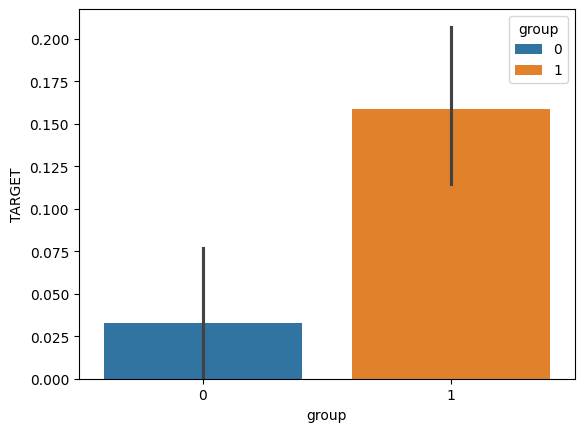

In [189]:
sns.barplot(x = 'group', y = 'TARGET', data = full, hue = 'group')